In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/fruit dataset/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini



##Importing Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from skimage import feature
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, accuracy_score

##Function to extract the Color Histogram :

This histogram represents the color distribution of the image. We will use this as the first part of our feature vector.

In [ ]:
def color_hist(img, bins = (10, 10, 10)):

  # Resizing the input image
  img = cv2.resize(img, (100, 100))
  
  # Calculating the histogram
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0, 180, 0, 256, 0, 256])
  
  # Normalising the Histogram
  cv2.normalize(hist, hist)
  
  # Flattening the histogram before returning
  return hist.flatten()

# Function to calculate HOG of the image

This represents the edges in our image. We will use this as the second part of our feature vector.

In [ ]:
def HOG_Calculate(image):

  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  # Flattening the HOG before returning
  return hog_image.flatten()

In [ ]:
def show_Hog_Image(image):
  # Resizing the input image
  image = cv2.resize(image, (100, 100))

  # Feature has been imported from the skimage library
  (hog, hog_image) = feature.hog(image, orientations=9, 
                      pixels_per_cell=(10, 10), cells_per_block=(2, 2), 
                      block_norm='L2-Hys', visualize=True, transform_sqrt=True, multichannel=True)

  plt.imshow((hog_image*255)[...,::-1])

#Importing Dataset

In [ ]:
# !pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d moltean/fruits
# !unzip fruits.zip

#Extracting Images and their Features from the Dataset

In [ ]:
# Root Directory for the Training Images Folder
rootdir = './fruits-360_dataset/fruits-360/Training'

# Features array
features = []
# Labels array
imageLables = []

imageCount = 0

# Looping over all the subdirectories, directories, and files in the Root directory
for subdir, dir, files in os.walk(rootdir):
  
  imageCount = 0
  # Looping over the images
  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the label from the image name
    imageLables.append(str(subdir).split('/')[-1])

    # Calculating the color histogram of the image
    colorDistribution = color_hist(img, (10, 10, 10))

    # Calculating the HOG for our image
    hogDistribution = HOG_Calculate(img)

    # Concatenating the above 2 form a feature and add that 2 the feature array
    features.append(np.concatenate((colorDistribution, hogDistribution)))

    imageCount += 1
    
    # Sampling the Dataset with maximum 100 images per sample because when we took the complete dataset, the RAM was crashing
    if imageCount > 200:
      break
    
# Converting the lists into numpy arrays for better performance
features = np.array(features)
imageLables = np.array(imageLables)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
imageLables = imageLables.reshape(len(imageLables), 1)
imageLables = onehot_encoder.fit_transform(imageLables)

In [ ]:
# Verifying that the training data has all the 131 labels
print(imageLables[0].shape)

(131,)


#Creating the Models

In [ ]:
model_ann_1 = keras.Sequential([keras.layers.Dense(12,input_shape=(len(features[0]),) ,activation='relu'), # Use appropriate values
                        
                         keras.layers.Dense(12,activation='relu'),
                      
                         keras.layers.Dense(imageLables[0].shape[0],activation='softmax')]) # 131 is no. of dimensions in the output layer

# Use the appropriate optimizer (gradient descent), loss function and metrics for evaluating classification accuracy
model_ann_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_ann_2 = keras.Sequential([keras.layers.Dense(24,input_shape=(len(features[0]),) ,activation='relu'), # Use appropriate values
                        
                         keras.layers.Dense(24,activation='relu'),
                      
                         keras.layers.Dense(imageLables[0].shape[0],activation='softmax')]) # 131 is no. of dimensions in the output layer

# Use the appropriate optimizer (gradient descent), loss function and metrics for evaluating classification accuracy
model_ann_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_ann_3 = keras.Sequential([keras.layers.Dense(128,input_shape=(len(features[0]),) ,activation='relu'), # Use appropriate values
                        
                         keras.layers.Dense(64,activation='relu'),

                         keras.layers.Dense(32,activation='relu'),
                      
                         keras.layers.Dense(imageLables[0].shape[0],activation='softmax')]) # 131 is no. of dimensions in the output layer

# Use the appropriate optimizer (gradient descent), loss function and metrics for evaluating classification accuracy
model_ann_3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#Training the Models


In [ ]:
model_ann_1.fit(features,imageLables, epochs=150)

Epoch 1/150
823/823 [==============================] - 8s 8ms/step - loss: 3.7989 - accuracy: 0.1090
Epoch 2/150
823/823 [==============================] - 6s 7ms/step - loss: 2.1000 - accuracy: 0.4056
Epoch 3/150
823/823 [==============================] - 6s 7ms/step - loss: 1.6139 - accuracy: 0.5235
Epoch 4/150
823/823 [==============================] - 6s 7ms/step - loss: 1.3594 - accuracy: 0.5944
Epoch 5/150
823/823 [==============================] - 8s 9ms/step - loss: 1.1939 - accuracy: 0.6419
Epoch 6/150
823/823 [==============================] - 6s 7ms/step - loss: 1.0612 - accuracy: 0.6854
Epoch 7/150
823/823 [==============================] - 4s 5ms/step - loss: 0.9563 - accuracy: 0.7138
Epoch 8/150
823/823 [==============================] - 7s 8ms/step - loss: 0.8688 - accuracy: 0.7397
Epoch 9/150
823/823 [==============================] - 6s 8ms/step - loss: 0.7952 - accuracy: 0.7613
Epoch 10/150
823/823 [==============================] - 6s 7ms/step - loss: 0.7317 - accura

In [ ]:
model_ann_2.fit(features,imageLables, epochs=50)

Epoch 1/50
823/823 [==============================] - 8s 9ms/step - loss: 2.6381 - accuracy: 0.3725
Epoch 2/50
823/823 [==============================] - 6s 8ms/step - loss: 0.9039 - accuracy: 0.7638
Epoch 3/50
823/823 [==============================] - 6s 8ms/step - loss: 0.4778 - accuracy: 0.8776
Epoch 4/50
823/823 [==============================] - 6s 8ms/step - loss: 0.2913 - accuracy: 0.9261
Epoch 5/50
823/823 [==============================] - 6s 8ms/step - loss: 0.1978 - accuracy: 0.9523
Epoch 6/50
823/823 [==============================] - 6s 7ms/step - loss: 0.1372 - accuracy: 0.9686
Epoch 7/50
823/823 [==============================] - 6s 8ms/step - loss: 0.1024 - accuracy: 0.9765
Epoch 8/50
823/823 [==============================] - 6s 7ms/step - loss: 0.0749 - accuracy: 0.9826
Epoch 9/50
823/823 [==============================] - 6s 7ms/step - loss: 0.0661 - accuracy: 0.9830
Epoch 10/50
823/823 [==============================] - 7s 8ms/step - loss: 0.0537 - accuracy: 0.9862

In [ ]:
model_ann_3.fit(features,imageLables, epochs=30)

Epoch 1/30
823/823 [==============================] - 11s 13ms/step - loss: 2.0811 - accuracy: 0.5007
Epoch 2/30
823/823 [==============================] - 10s 12ms/step - loss: 0.3455 - accuracy: 0.9105
Epoch 3/30
823/823 [==============================] - 10s 12ms/step - loss: 0.1280 - accuracy: 0.9670
Epoch 4/30
823/823 [==============================] - 10s 12ms/step - loss: 0.0783 - accuracy: 0.9788
Epoch 5/30
823/823 [==============================] - 10s 12ms/step - loss: 0.0685 - accuracy: 0.9805
Epoch 6/30
823/823 [==============================] - 10s 12ms/step - loss: 0.0533 - accuracy: 0.9840
Epoch 7/30
823/823 [==============================] - 10s 12ms/step - loss: 0.0488 - accuracy: 0.9841
Epoch 8/30
823/823 [==============================] - 10s 13ms/step - loss: 0.0401 - accuracy: 0.9876
Epoch 9/30
823/823 [==============================] - 10s 12ms/step - loss: 0.0531 - accuracy: 0.9829
Epoch 10/30
823/823 [==============================] - 10s 12ms/step - loss: 0.020

#Checking our models on a test image

Below is an image of a fruit of the class 'Apple Golden 1'

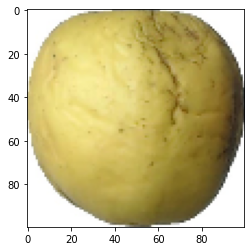

In [ ]:
# Path of the Image
imagePath = "./fruits-360-original-size/fruits-360-original-size/Training/apple_golden_1/r0_0.jpg"

# Reading the Image
testImage = cv2.resize(cv2.imread(imagePath), (100, 100))
plt.imshow(testImage[:,:,::-1])

Below is the HOG of the above image

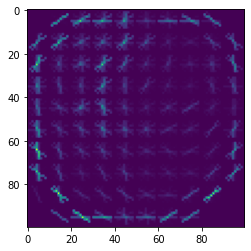

In [ ]:
# We are plotting using matplotlib which is showing distorted colors. 
# But the 2 colors are sufficient to correctly visualize the HOG.
show_Hog_Image(testImage)

Checking our Model for this image

In [ ]:
# Calculating the Feature vector for this test image
colorDistribution = np.array(color_hist(testImage, (10, 10, 10)))
hogDistribution = np.array(HOG_Calculate(testImage))

# Feature Vector
feature_array = np.array([np.concatenate((colorDistribution, hogDistribution))])

# Expected Output
expected_output = np.array(["Apple Golden 1"])
expected_output = expected_output.reshape(len(expected_output), 1)
expected_output = onehot_encoder.transform(expected_output)

# Predicting the output
output_1 = model_ann_1.predict(feature_array)[0]
output_2 = model_ann_2.predict(feature_array)[0]
output_3 = model_ann_3.predict(feature_array)[0]

# Decoding the output
originalLabels = onehot_encoder.categories_[0]
decoded_output_1 = [originalLabels[i] for i in range(len(output_1)) if output_1[i] == max(output_1)][0]
decoded_output_2 = [originalLabels[i] for i in range(len(output_2)) if output_2[i] == max(output_2)][0]
decoded_output_3 = [originalLabels[i] for i in range(len(output_3)) if output_3[i] == max(output_3)][0]

# Printing the Model Output
print("Model 1 Predicted This Fruit to be:", decoded_output_1)
print("Model 2 Predicted This Fruit to be:", decoded_output_2)
print("Model 3 Predicted This Fruit to be:", decoded_output_3)

# Evaluating model on this output
model_ann_1.evaluate(feature_array, expected_output)
model_ann_2.evaluate(feature_array, expected_output)
model_ann_3.evaluate(feature_array, expected_output)

Model 1 Predicted This Fruit to be: Apple Golden 1
Model 2 Predicted This Fruit to be: Apple Golden 1
Model 3 Predicted This Fruit to be: Apple Golden 1
1/1 [==============================] - 0s 144ms/step - loss: 5.0818e-04 - accuracy: 1.0000


[0.0005081792478449643, 1.0]

#Extensive Testing on Final Test Images to check the desired Metrics

Processing the Test images and extracting the features and the labels

In [ ]:
# Root Directory where the Test Images are stored
rootdir = './fruits-360_dataset/fruits-360/Test'

# Features array
features_TEST = []
# Real Labels array
imageLables_TEST = []
count = 0

for subdir, dir, files in os.walk(rootdir):
  count = 0
  for file in files:
    
    # Reading the image
    img = cv2.imread(os.path.join(subdir, file))

    # Extracting the Label
    imageLables_TEST.append(str(subdir).split('/')[-1])

    # Calculating the Color Distribution and HOG of the image
    colorDistribution = color_hist(img, (10, 10, 10))
    hogDistribution = HOG_Calculate(img)

    # Appending the Feature Vector of our Image into the Features array
    features_TEST.append(np.concatenate((colorDistribution, hogDistribution)))
    count += 1

    # Sampling the Test Dataset with maximum 50 images per sample
    if(count > 50):
      break

# Converting the Feature array and the Image Labels array into numpy array for better performance
features_TEST = np.array(features_TEST)
imageLables_TEST = np.array(imageLables_TEST)
imageLables_TEST = imageLables_TEST.reshape(len(imageLables_TEST), 1)
imageLables_TEST = onehot_encoder.transform(imageLables_TEST)

Checking Accuracy on all Test Images

In [ ]:
model_ann_1.evaluate(features_TEST,imageLables_TEST)
model_ann_2.evaluate(features_TEST,imageLables_TEST)
model_ann_3.evaluate(features_TEST,imageLables_TEST)

209/209 [==============================] - 1s 5ms/step - loss: 1.1116 - accuracy: 0.8657


[1.1116398572921753, 0.8657386898994446]

Checking the Desired Metrics asked in the Assignment

In [ ]:
def getMetricsFromReport(report):
  # Classification Report has to be generated via classification_report imported from sklearn.metrics
  # For successful parsing
  r = report.split('\n')[-2].split()
  answer = []
  for i in r:
    try:
      answer.append(float(i.strip()))
    except Exception as e:
      pass

  (p, rec, f1, sup) = answer
  return (p, rec, f1, sup)

In [ ]:
y_pred_1 = model_ann_1.predict(features_TEST)
y_pred_2 = model_ann_2.predict(features_TEST)
y_pred_3 = model_ann_3.predict(features_TEST)
decoded_y_pred_1 = []
decoded_y_pred_2 = []
decoded_y_pred_3 = []
decoded_y_test = []
for pred in y_pred_1:
  decoded = [originalLabels[i] for i in range(len(pred)) if pred[i] == max(pred)]
  decoded_y_pred_1.append(decoded)

for pred in y_pred_2:
  decoded = [originalLabels[i] for i in range(len(pred)) if pred[i] == max(pred)]
  decoded_y_pred_2.append(decoded)

for pred in y_pred_3:
  decoded = [originalLabels[i] for i in range(len(pred)) if pred[i] == max(pred)]
  decoded_y_pred_3.append(decoded)

for label in imageLables_TEST:
  decoded = [originalLabels[i] for i in range(len(label)) if label[i] == max(label)]
  decoded_y_test.append(decoded)

Printing the Precision, Recall and F1-Score for all fruits

In [ ]:
report_1 = classification_report(decoded_y_pred_1, decoded_y_test)
print(report_1)

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      1.00      1.00        51
 Apple Crimson Snow       0.33      0.77      0.47        22
     Apple Golden 1       0.75      1.00      0.85        38
     Apple Golden 2       0.78      0.77      0.78        52
     Apple Golden 3       1.00      0.61      0.76        83
 Apple Granny Smith       0.92      1.00      0.96        47
    Apple Pink Lady       0.96      0.72      0.82        68
        Apple Red 1       0.82      0.74      0.78        57
        Apple Red 2       1.00      0.84      0.91        61
        Apple Red 3       0.84      1.00      0.91        43
Apple Red Delicious       1.00      0.94      0.97        54
 Apple Red Yellow 1       0.37      0.83      0.51        23
 Apple Red Yellow 2       0.92      0.90      0.91        52
            Apricot       0.96      0.98      0.97        50
            Avocado       0.96      0.74      0.84        66
       Avocado ripe    

In [ ]:
report_2 = classification_report(decoded_y_pred_2, decoded_y_test)
print(report_2)

                     precision    recall  f1-score   support

     Apple Braeburn       0.80      0.93      0.86        44
 Apple Crimson Snow       0.88      0.87      0.87        52
     Apple Golden 1       0.78      0.98      0.87        41
     Apple Golden 2       1.00      0.94      0.97        54
     Apple Golden 3       1.00      0.94      0.97        54
 Apple Granny Smith       1.00      0.93      0.96        55
    Apple Pink Lady       0.90      0.88      0.89        52
        Apple Red 1       0.88      0.83      0.86        54
        Apple Red 2       0.94      1.00      0.97        48
        Apple Red 3       0.98      0.94      0.96        53
Apple Red Delicious       1.00      0.89      0.94        57
 Apple Red Yellow 1       0.92      0.85      0.89        55
 Apple Red Yellow 2       0.88      0.90      0.89        50
            Apricot       0.76      0.87      0.81        45
            Avocado       1.00      1.00      1.00        51
       Avocado ripe    

In [ ]:
report_3 = classification_report(decoded_y_pred_3, decoded_y_test)
print(report_3)

                     precision    recall  f1-score   support

     Apple Braeburn       0.88      0.88      0.88        51
 Apple Crimson Snow       0.90      0.81      0.85        57
     Apple Golden 1       0.49      0.83      0.62        30
     Apple Golden 2       0.98      0.79      0.88        63
     Apple Golden 3       1.00      0.75      0.86        68
 Apple Granny Smith       0.98      0.88      0.93        57
    Apple Pink Lady       1.00      0.85      0.92        60
        Apple Red 1       0.61      0.76      0.67        41
        Apple Red 2       0.92      0.98      0.95        48
        Apple Red 3       0.98      0.91      0.94        55
Apple Red Delicious       1.00      1.00      1.00        51
 Apple Red Yellow 1       0.90      0.78      0.84        59
 Apple Red Yellow 2       0.84      0.98      0.91        44
            Apricot       0.78      0.95      0.86        42
            Avocado       0.92      0.98      0.95        48
       Avocado ripe    

In [ ]:
p_1, rec_1, f1_1, sup_1 = getMetricsFromReport(report_1)

In [ ]:
p_2, rec_2, f1_2, sup_2 = getMetricsFromReport(report_2)

In [ ]:
p_3, rec_3, f1_3, sup_3 = getMetricsFromReport(report_3)

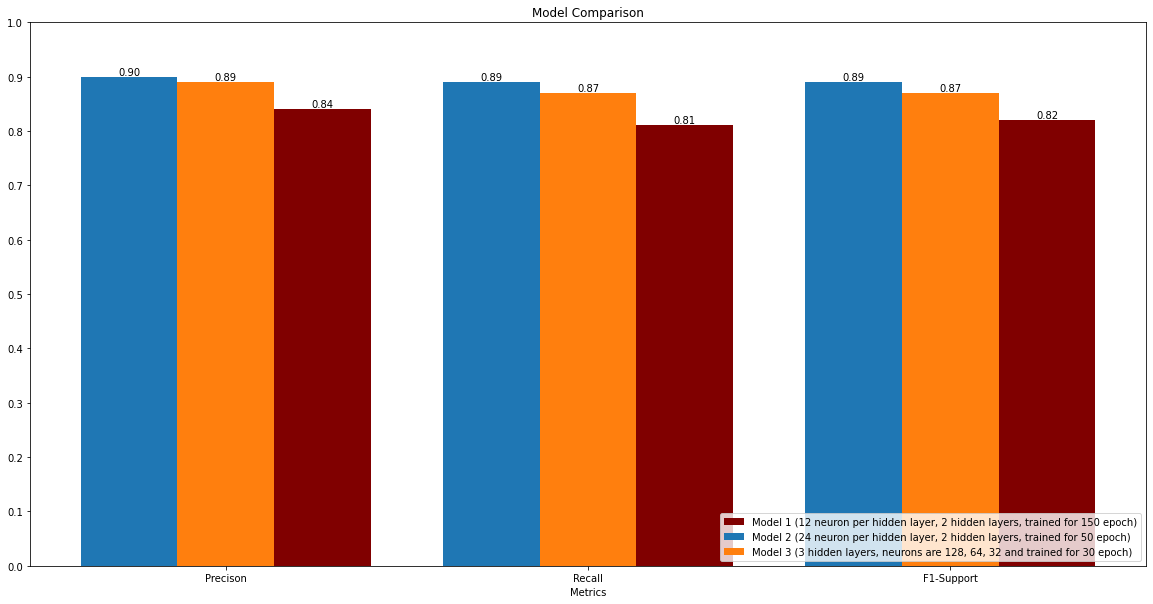

In [ ]:
X = ['Precison', 'Recall', 'F1-Support']
Y_1 = [p_1, rec_1, f1_1]
Y_2 = [p_2, rec_2, f1_2]
Y_3 = [p_3, rec_3, f1_3]

X_Axis = np.arange(3, 12, 3)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(20)

b1 = plt.bar(X_Axis + 0.8, Y_1, 0.8, label = 'Model 1 (12 neuron per hidden layer, 2 hidden layers, trained for 150 epoch)', color='maroon', zorder=3)
b2 = plt.bar(X_Axis - 0.8, Y_2, 0.8, label = 'Model 2 (24 neuron per hidden layer, 2 hidden layers, trained for 50 epoch)', zorder=3)
b3 = plt.bar(X_Axis, Y_3, 0.8, label = 'Model 3 (3 hidden layers, neurons are 128, 64, 32 and trained for 30 epoch) ', zorder=3)

# plt.bar(X_Axis, Y_f1, 0.2, label = 'F1')
# plt.bar(X_Axis + 0.15, Y_sup, 0.2, label = 'Support')

for rect in b1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')



for rect in b2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for rect in b3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# f = plt.figure()
# plt.grid(True, zorder=0)
plt.xticks(X_Axis, X)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Metrics")
plt.title("Model Comparison")
plt.legend(loc=4)

plt.show()